# 3.1 Machine Learning - Introduction

This notebook demonstrates the basics of using SparkML for Machine Learning. We will build a few different regression models, tune their parameters and evaluate their performance.

We will be using the wine quality dataset from: https://archive.ics.uci.edu/ml/datasets/Wine+Quality, which captures various physical properties of wines (alcohol content, acidity etc) and their quality as apprised by wine experts (`data/winequality-white.csv`).

Let's preview the data first:

In [2]:
%%sh

# preview the data file
gsutil cp gs://graphenoxidexyz/demo/data/winequality-white.csv .
head -n 5 winequality-white.csv

"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9.5;6
8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;10.1;6
7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6


Copying gs://graphenoxidexyz/demo/data/winequality-white.csv...
/ [1 files][258.2 KiB/258.2 KiB]                                                
Operation completed over 1 objects/258.2 KiB.                                    


It's a semi-colon delimited text file with the header.

SparkML operates on DataFrames so we need to create one with our data:

In [3]:
# load contents of winequality-white.csv to spark DataFrma
# we need to specify the custom separator `;`
inputDF = spark.read.csv('gs://graphenoxidexyz/demo/data/winequality-white.csv',header='true', inferSchema='true', sep=';')

In [4]:
# let's see the schema and the number of rows
inputDF.printSchema()
print("Rows: %s" % inputDF.count())

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

Rows: 4898


Our dataframe is relatively small. In fact it is so small that we could easily analyse using standard `python` tools. However the code below,  which is currenlty running on a sigle computer can be easily run on large spark clusters to analyse dataframes with billions of rows.

Let's see as sample of the data:

In [6]:
inputDF.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Here we will show a few example of using Spark ML to build regression models that **predict the quality of wine based on its properties**.

We have called the new dataframe `dataDF` and applied caching to it. This will tell Spark to try to cache the data in memory for faster access.

### The Basics of Model Building


We will now build a simple linear *regression model*.

Spark requires that all the predictors (features) are combined into a single feature vector.

We can use `VectorAssembler` to build it from selected columns of our `DataFrame` (we will use all properties):

In [8]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# select the columns to be used as the features (all except `quality`)
featureColumns = [c for c in inputDF.columns if c != 'quality']

# create and configure the assembler
assembler = VectorAssembler(inputCols=featureColumns, 
                            outputCol="features")

# transform the original data
dataDF = assembler.transform(inputDF)
dataDF.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- features: vector (nullable = true)



In [10]:
dataDF.limit(3).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,features
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1...."
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99..."
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951..."


We can use the assembler to `transform` our input dataframe into one that includes the feature vector (`features`) shown above.

Now we are ready to train a simple regession model:

In [11]:
from pyspark.ml.regression import LinearRegression

# fit a `LinearRegression` model using features in colum `features` and label in column `quality`
lr = LinearRegression(maxIter=30, regParam=0.3, elasticNetParam=0.3, featuresCol="features", labelCol="quality")
lrModel = lr.fit(dataDF)

We can now look at the linear regression the coefficients:  

In [12]:
for t in zip(featureColumns, lrModel.coefficients):
    print t

('fixed acidity', 0.0)
('volatile acidity', -0.79168917102449954)
('citric acid', 0.0)
('residual sugar', 0.0)
('chlorides', -0.10550323778501457)
('free sulfur dioxide', 0.0)
('total sulfur dioxide', 0.0)
('density', 0.0)
('pH', 0.0)
('sulphates', 0.0)
('alcohol', 0.19726471378350921)


You may notice that for most properties the coefficients are zero, which means that they do not contribute (according to this specific model) to wine quality. 

This model is using elastic net regularizations which naturally 'selects' the most important variables (as it in turns uses LASSO)

We can now use the model to make predictions:

In [14]:
# predict the quality, the predicted quality will be saved in `prediction` column
predictionsDF = lrModel.transform(dataDF)
predictionsDF.limit(3).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,features,prediction
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1....",5.546351
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99...",5.660263
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951...",5.794351


Now we can evaluate the performance of our model with Root Mean Squared Error:

In [15]:
from pyspark.ml.evaluation import RegressionEvaluator

# create a regression evaluator with RMSE metrics

evaluator = RegressionEvaluator(
    labelCol='quality', predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictionsDF)
print("Root Mean Squared Error (RMSE) = %g" % rmse)

Root Mean Squared Error (RMSE) = 0.794772


To get some idea of how good the model is we can try to compare it to the 'zero' model that always predicts the average  `quality`.

In [16]:
from pyspark.sql.functions import *

# calculate the average wine quality
avgQuality = inputDF.groupBy().avg('quality').first()[0]
print(avgQuality)

# compute the 'zero' model predictions
# `lit` function creates a 'literal' column that is column with the provided value in all rows
zeroModelPredictionsDF = dataDF.select(col('quality'), lit(avgQuality).alias('prediction'))

# evaluate the 'zero' model
zeroModelRmse = evaluator.evaluate(zeroModelPredictionsDF)
print("RMSE of 'zero model' = %g" % zeroModelRmse)

5.87790935076
RMSE of 'zero model' = 0.885548


So we did a little bit better. But this is actually a very biased 'best case' estimate of the RMSE. 

**Why?**

### Traning  Evaluating Models with Pipelines

We will first split our data into traning and testing set and then train a regression model only on the traning set and use the test set for evaluation. 

Rather then using our transformed `dataDF` we will chaing the preprocessing (vector assembling) and model traning into a simple `Pipeline`.

In general pipelines may include may steps dealing with feature preprocessing, extraction etc.

In [17]:
# split the input data into traning and test dataframes with 70% to 30% weights
(trainingDF, testDF) = inputDF.randomSplit([0.7, 0.3])

In [18]:
from pyspark.ml import Pipeline

# construct the `Pipeline` that with two stages: the `vector assembler` and `regresion model estimator`
pipeline = Pipeline(stages=[assembler, lr])

# train the pipleline on the traning data
lrPipelineModel = pipeline.fit(trainingDF)

# make predictions
traningPredictionsDF = lrPipelineModel.transform(trainingDF)
testPredictionsDF = lrPipelineModel.transform(testDF)

# evaluate the model on test and traning data
print("RMSE on traning data = %g" % evaluator.evaluate(traningPredictionsDF))

print("RMSE on test data = %g" % evaluator.evaluate(testPredictionsDF))

RMSE on traning data = 0.790519
RMSE on test data = 0.802028


As we can see the the RMSE on test data is slighly worse than on the traning data. The difference is not significant though.

** Why? **

### Model Tuning

For many models their perfomance signficanly depends on the model parameters. They need to be chosen for each data set differnly and the process of finding the best parameters is called 'model tuning'.

In our previous example we used to parameters for `LinearRegression`: `regParam=0.3, elasticNetParam=0.3` with ad hoc values.

Perhaps we can get a better model if we can tune these parameters. 

Spark ML comes with a ready to use parameter optimiser that uses *cross-validation* to select the best set of parameter from the provided *search grid*.

In [19]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

# create a search grid with the cross-product of the parameter values (9 pairs)
search_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.3, 0.6]) \
    .addGrid(lr.elasticNetParam, [0.4, 0.6, 0.8]).build()

# use `CrossValidator` to tune the model
cv = CrossValidator(estimator = pipeline, estimatorParamMaps = search_grid, evaluator = evaluator, numFolds = 3)
cvModel = cv.fit(trainingDF)

In [20]:
# evaluate the tuned model
cvTestPredictionsDF = cvModel.transform(testDF)
print("RMSE on test data with CV = %g" % evaluator.evaluate(cvTestPredictionsDF))

RMSE on test data with CV = 0.759604


This model is slightly better than the guessed model. 

We can also check the cross-validation estimates of RMSE for each of the tested models:

In [21]:
print(cvModel.avgMetrics)

[0.7515115063475108, 0.7984300451606503, 0.8434735820693686, 0.7515115063475108, 0.8182078407574003, 0.8749263515559589, 0.7515115063475108, 0.832731524654004, 0.884981692063942]


### Traning Random Forest

Linear regression is a very simple model. Perhaps we can do better with a more complex one? Let's try to use RandomForest.

In [22]:
from pyspark.ml.regression import RandomForestRegressor

# define the random forest estimator
rf = RandomForestRegressor(featuresCol="features", labelCol="quality", numTrees=100, maxBins=128, maxDepth=20, \
                           minInstancesPerNode=5, seed=33)
rfPipeline = Pipeline(stages=[assembler, rf])

# train the random forest model
rfPipelineModel = rfPipeline.fit(trainingDF)

Let's evaluate the model:

In [23]:
rfTrainingPredictions = rfPipelineModel.transform(trainingDF)
rfTestPredictions = rfPipelineModel.transform(testDF)
print("Random Forest RMSE on traning data = %g" % evaluator.evaluate(rfTrainingPredictions))
print("Random Forest RMSE on test data = %g" % evaluator.evaluate(rfTestPredictions))

Random Forest RMSE on traning data = 0.409117
Random Forest RMSE on test data = 0.628963


Random forest does indeed better than linear regression. Please also notice the difference bewteen the peformance on the traning ang testing sets.


We can 'extract' the actual random forest model from the `Pipeline` stage. We can use it for example to look at variable importance measure: 

In [24]:
rfModel = rfPipelineModel.stages[1]
rfModel.featureImportances

SparseVector(11, {0: 0.0583, 1: 0.118, 2: 0.0671, 3: 0.0635, 4: 0.0812, 5: 0.1081, 6: 0.0749, 7: 0.1161, 8: 0.0622, 9: 0.0576, 10: 0.1932})

The model as well as the entire pipelines can be saved to disk and then loaded when needed.

In [26]:
# save the random forest pipeline to the disk
rfPipelineModel.write().overwrite().save('gs://graphenoxidexyz/demo/data/output/rf.model')

In [27]:
# load the andom forest pipeline from the dist
from pyspark.ml import PipelineModel
loadedModel = PipelineModel.load('gs://graphenoxidexyz/demo/data/output/rf.model')
loadedPredictionsDF = loadedModel.transform(testDF)

In [28]:
# evaluate the model again to see if we get the same performance
print("Loaded model RMSE = %g" % evaluator.evaluate(loadedPredictionsDF))

Loaded model RMSE = 0.628963


### Data visualisation (bonus)

Here we will use Principal Component Analysis to reduce the data dimesionalit so that we can plot the in 2D space.

As before we will create a multi step pipeline that will:

* assemble the feature vector from all predictors
* normalise the features (to 0 mean and 1 stddev) 
* extract two most significant PCA components


In [30]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

all_assembler = VectorAssembler(
    inputCols=featureColumns,
    outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="norm_features")
pca = PCA(k=2, inputCol="norm_features", outputCol="pca_features")

pca_pipeline = Pipeline(stages=[all_assembler, normalizer, pca])

pca_model = pca_pipeline.fit(inputDF)

pca_model.transform(inputDF).select('features', 'norm_features', 'pca_features').limit(3).toPandas()

,features,norm_features,pca_features
0,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1....","[0.0394465814369, 0.00152151099828, 0.00202868...","[0.00738132933449, -0.167246598583]"
1,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99...","[0.0472672209264, 0.00225082004412, 0.00255092...","[-0.146221111792, -0.153299522903]"
2,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951...","[0.0789116854197, 0.00272781134784, 0.00389687...","[0.0445900247096, -0.104780780881]"


The `pca_features` column now contains the reduced 2D representation of all other features.

We can now use it to visualise a 30% sample of the data. The color represents quality of wine.


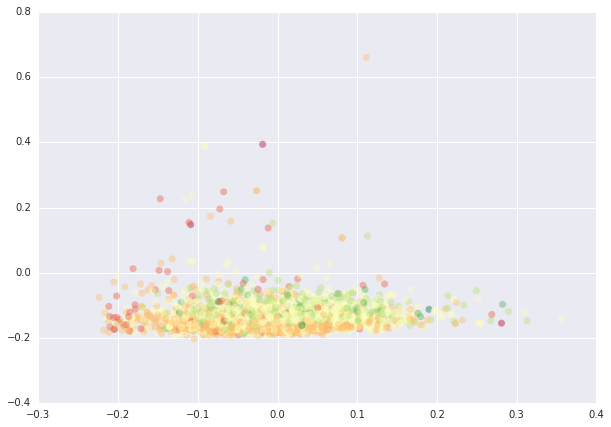

In [31]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)
pca_data = pca_model.transform(inputDF)

sampling_fraction = 0.5

pca_xy = np.matrix(map(lambda r:r.pca_features.array, pca_data.sample(False, sampling_fraction, 13).collect()))
pca_colors = map(lambda r: float(r.quality),inputDF.select('quality').sample(False, sampling_fraction, 13).collect())
plt.close()
plt.scatter(pca_xy[:,0], pca_xy[:,1], c=pca_colors, alpha=0.4, cmap=plt.get_cmap('RdYlGn'), edgecolors='none', s=50)
plt.grid(True)
plt.show()
display()